<a href="https://colab.research.google.com/github/yuukicammy/automatic-watermark-detection/blob/gcolab/Watermarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Colabolatory Setup
Mount the Google Drive that contains the source code and wartermarked image files.

---



In [28]:
#### predefined parameters ###
# Google Drive directory that contains the source code and wartermarked image files.
wdir = '/MyDrive/automatic-watermark-detection'

# the directory that containes the wartermarked images.
# please speficy the relative path from 'wdir'
wartermkarked = 'wartermarked_images'

# the image size (pixels) to be used during processing.
width = 500
height = 500

In [29]:
# mount Google Drive
from google.colab import drive 
drive.mount('/content/drive')

wdir = '/content/drive' + wdir

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# change working directory
# please specify your Google Drive directory that contains the target source code and wartermarked image files.
%cd $wdir
%pwd
!ls

/content/drive/MyDrive/automatic-watermark-detection
array.npz				 Resized
closed-form-matting			 resize.py
coco_dataset				 src
final					 wartermarked_images
main_cocoset.py				 wartermarked_images_removed
main.py					 wartermarked_images_resized
Matting-Levin-Lischinski-Weiss-PAMI.pdf  Watermarking.ipynb
README.md				 watermark.png
references.txt


Resize the target wartermarked images.

In [31]:
import os, cv2, warnings
forldername = os.path.join(wdir, wartermkarked)
resizeddir = os.path.join(wdir, wartermkarked +'_resized')
resultdir = os.path.join(wdir, wartermkarked +'_removed')

if not os.path.exists(forldername):
   warnings.warn("{} does not exist.".format(forldername), UserWarning)

if not os.path.exists(resizeddir):
   os.mkdir(resizeddir)

if not os.path.exists(resultdir):
   os.mkdir(resultdir)

original_shape = [] # (width, height, channel)
filenames = []
for r, dirs, files in os.walk(forldername):
    # Get all the images
    for file in files:
        img = cv2.imread(os.sep.join([r, file]))
        if img is not None:
          original_shape.append(img.shape)
          filenames.append(file)
          print('original shape: {}'.format(img.shape))
          img = cv2.resize(img,(width, height))
          print('resized shape:  {}'.format(img.shape))
          cv2.imwrite(os.path.join(resizeddir, file), img)
        else:
            print("%s not found." % (file))

original shape: (500, 500, 3)
resized shape:  (500, 500, 3)
original shape: (500, 500, 3)
resized shape:  (500, 500, 3)
original shape: (500, 500, 3)
resized shape:  (500, 500, 3)
original shape: (500, 500, 3)
resized shape:  (500, 500, 3)
original shape: (500, 500, 3)
resized shape:  (500, 500, 3)
original shape: (500, 500, 3)
resized shape:  (500, 500, 3)
original shape: (500, 500, 3)
resized shape:  (500, 500, 3)
original shape: (500, 500, 3)
resized shape:  (500, 500, 3)
original shape: (500, 500, 3)
resized shape:  (500, 500, 3)
original shape: (500, 500, 3)
resized shape:  (500, 500, 3)


### Automatic watermark removal
This is the Jupyter notebook for automatic watermark removal code.
We follow the scripts till watermark estimation and then try to solve the watermarking problem.

Computing gradients.
Computing median gradients.
(249, 251)


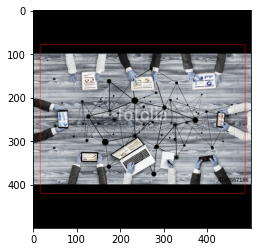

In [5]:
%matplotlib inline
from src import *

gx, gy, gxlist, gylist = estimate_watermark(resizeddir)

est = poisson_reconstruct(gx, gy)
cropped_gx, cropped_gy = crop_watermark(gx, gy)
est2 = poisson_reconstruct(cropped_gx, cropped_gy)

# random photo
im, start, end = watermark_detector(img, cropped_gx, cropped_gy, 200/255, 220/255, True)

plt.imshow(im)
plt.show()

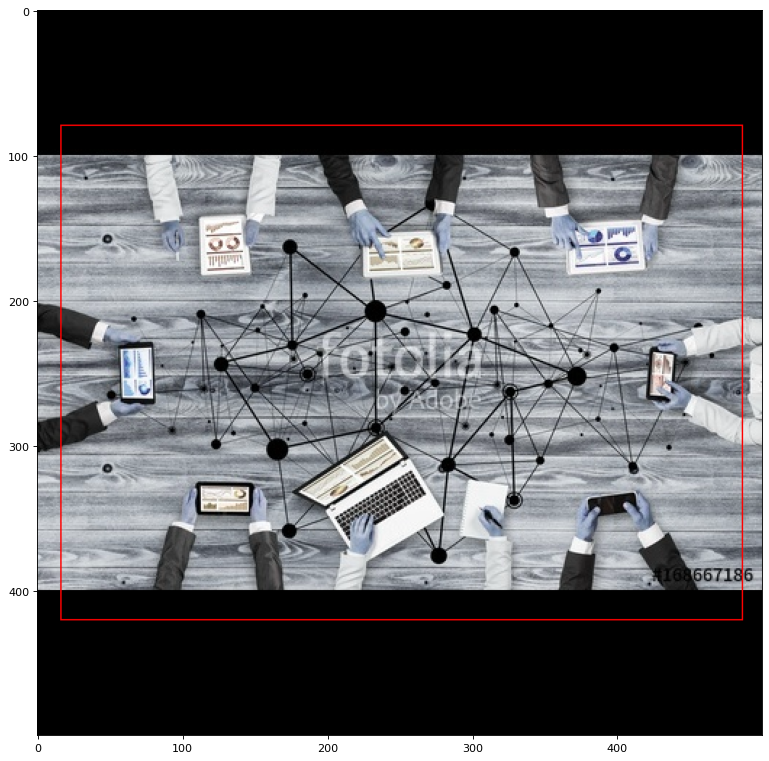

In [6]:
plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(im)

In [7]:
print(cropped_gx.shape, cropped_gy.shape, est.shape, est2.shape)
print(im.shape, start, end)

(341, 470, 3) (341, 470, 3) (500, 500, 3) (341, 470, 3)
(500, 500, 3) (79, 16) (341, 470)


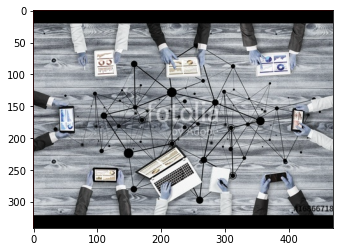

In [8]:
plt.imshow(im[start[0]:(start[0]+end[0]), start[1]:(start[1]+end[1]), :])

In [9]:
'''
This is the part where we get all the images, extract their parts, and then add it to our matrix
'''
num_images = len(gxlist)
images_cropped = np.zeros((num_images,) + cropped_gx.shape).astype(float)

# Store all the watermarked images
# start, and end are already stored
# just crop and store image
image_paths = []
_s, _e = start, end
index = 0

# Iterate over all images
for r, dirs, files in os.walk(resizeddir):
    for file in files:
        _img = cv2.imread(os.sep.join([r, file])).astype(float)
        if _img is not None:
            _img = _img/255
            # estimate the watermark part
            image_paths.append(os.sep.join([r, file]))
            _img = _img[_s[0]:(_s[0]+_e[0]), _s[1]:(_s[1]+_e[1]), :]
            # add to list images
            images_cropped[index, :, :, :] = _img
            index+=1
        else:
            print("%s not found."%(file))

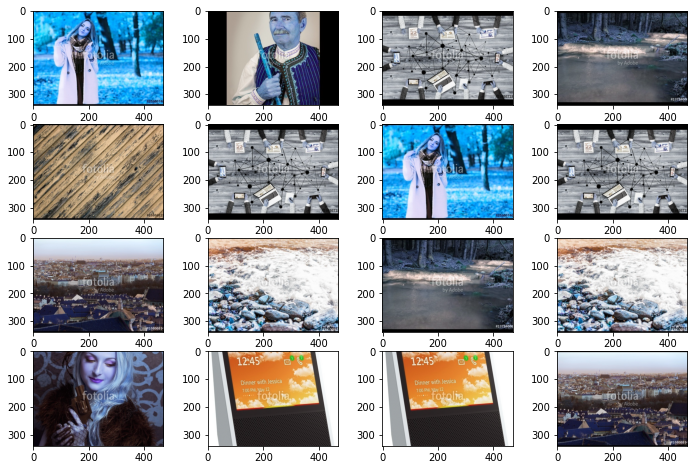

In [10]:
# Print some random indices extracted
N = 4
random_indices = np.random.randint(index, size=(N*N,))
fig, axes = plt.subplots(N, N, figsize=(12, 8))
for i, val in enumerate(random_indices):
  axes[int(i/N), i%N].imshow(images_cropped[val, :, :, :])

### Image reconstruction
Here comes the tougher part. We have an initial estimate for the watermark `Wm, cropped_gx, cropped_gy` and `est`. Using this, we solve the problem of Multi-image matting and reconstruction. We have a list of images, `images_cropped`, and we have to estimate `W` and `alpha` by reiterating the following 3 steps: 
- Image-Watermark detection
- Watermark update
- Matte update

Finally, we do a Matte and blend factor initialization to determine the constant and normalized matte.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [12]:
class Net(nn.Module):
  def __init__(self, num_images, m, n, channels, est):
    super(Net, self).__init__()
    self.sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
    self.sobel_y = torch.tensor(np.transpose([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]), dtype=torch.float32)

    self.sobel_x_filter = torch.stack([self.sobel_x, self.sobel_x, self.sobel_x])
    self.sobel_x_filter = torch.stack([self.sobel_x_filter, self.sobel_x_filter, self.sobel_x_filter])

    self.sobel_y_filter = torch.stack([self.sobel_y, self.sobel_y, self.sobel_y])
    self.sobel_y_filter = torch.stack([self.sobel_y_filter, self.sobel_y_filter, self.sobel_y_filter])

    self.I = nn.Parameter(torch.tensor(np.random.randn(num_images, channels, m, n), dtype=torch.float32))
    self.alpha = nn.Parameter(torch.tensor(np.random.rand(channels, m, n), dtype=torch.float32))
    self.W_m = nn.Parameter(torch.tensor(est))
    self.W_median = nn.Parameter(torch.tensor(est))
    self.W = nn.Parameter(torch.tensor(np.stack([est for _ in range(num_images)])))
    self.l_i = 0.5
    self.l_w = 0.01
    self.l_alpha = 0.01
    self.beta = 0.01
    self.gamma = 1

  def result(self):
    return self.I.to('cpu').detach().numpy().copy(), self.W.to('cpu').detach().numpy().copy()

  def to_device(self, device):
    self.I.to(device)
    self.W.to(device)
    self.alpha.to(device)
    self.sobel_x_filter.to(device)
    self.sobel_y_filter.to(device)
    self.W_m.to(device)
    self.W_median.to(device)
    
  def phi_func(self, mtensor, epsilon=0.001):
    return torch.sqrt(mtensor + epsilon**2)

  # E_data
  def E_data(self, I, W, J, alpha):
      # print("alpha shape: {}".format(alpha.shape))
      # print("W shape: {}".format(W.shape))
      # print("I shape: {}".format(I.shape))
      # print("J shape: {}".format(J.shape))

      est_error = torch.multiply(alpha, W) + torch.multiply(1-alpha, I) - J
      est_error = self.phi_func(torch.square(est_error))
      est_error = torch.sum(est_error)
      return est_error

  def same_padding(self, kernel_size):
      return (kernel_size[1]//2, kernel_size[0] // 2)

  # regularizer term for I, W
  def E_reg(self, I, alpha):
      alpha_ = alpha.unsqueeze(0).to(self.device)
      self.sobel_x_filter = self.sobel_x_filter.to(alpha.device)
      self.sobel_y_filter = self.sobel_y_filter.to(alpha.device)
      #print("alpha device: {}".format(alpha_.device))
      #print("sobel_x_filter device: {}".format(self.sobel_x_filter.device))

      ax = F.conv2d(alpha_, self.sobel_x_filter, stride=1, padding=self.same_padding(self.sobel_x_filter.shape))
      ay = F.conv2d(alpha_, self.sobel_y_filter, stride=1, padding=self.same_padding(self.sobel_y_filter.shape))
      Ix2 = torch.square(F.conv2d(I, self.sobel_x_filter, stride=1, padding=self.same_padding(self.sobel_x_filter.shape)))
      Iy2 = torch.square(F.conv2d(I, self.sobel_y_filter, stride=1, padding=self.same_padding(self.sobel_y_filter.shape)).double())
      est_error = torch.multiply(torch.abs(ax), Ix2) + torch.multiply(torch.abs(ay), Iy2)
      est_error = torch.sum(self.phi_func(est_error))
      return est_error

  # regularization term for alpha
  def E_reg_alpha(self, alpha):
      alpha_ = alpha.unsqueeze(0).to(self.device)
      ax2 = torch.square(F.conv2d(alpha_, self.sobel_x_filter, stride=1, padding=self.same_padding(self.sobel_x_filter.shape)).double())
      ay2 = torch.square(F.conv2d(alpha_, self.sobel_y_filter, stride=1, padding=self.same_padding(self.sobel_y_filter.shape)).double())
      est_error = torch.sum(self.phi_func(ax2 + ay2))
      return est_error
      
  # fidelity term
  # W = all watermarks
  def E_f(self, alpha, W, W_m):
      aW = torch.multiply(alpha, W).to(self.device)
      # find edge map of alpha*W
      aWx = F.conv2d(aW, self.sobel_x_filter, stride=1, padding=self.same_padding(self.sobel_x_filter.shape))
      aWy = F.conv2d(aW, self.sobel_y_filter, stride=1, padding=self.same_padding(self.sobel_y_filter.shape))
      aW_ = torch.sqrt(torch.square(aWx) + torch.square(aWy))
      
      # find edge map of W_m
      W_m__ = W_m.unsqueeze(0).to(self.device)
      W_mx = F.conv2d(W_m__, self.sobel_x_filter, stride=1, padding=self.same_padding(self.sobel_x_filter.shape))
      W_my = F.conv2d(W_m__, self.sobel_y_filter, stride=1, padding=self.same_padding(self.sobel_y_filter.shape))
      W_m_ = torch.sqrt(torch.square(W_mx) + torch.square(W_my))
      
      return torch.sum(self.phi_func(torch.square(aW_ - W_m_)))

  # auxiliary term
  def E_aux(self, W, W_k):
      return torch.sum(torch.abs(W - W_k))

  def forward(self, J):
      loss = self.E_data(self.I, self.W, J, self.alpha)  + self.l_i*self.E_reg(self.I, self.alpha) + self.l_w*self.E_reg(self.W, self.alpha) + self.beta*self.E_f(self.alpha, self.W, self.W_m) + self.gamma*self.E_aux(self.W_median, self.W)
      return loss


In [14]:
# define the variables
# plt.imshow(PlotImage(est2))

num_images, m, n, chan = images_cropped.shape

# NHWC to NCHW
W = np.transpose(est2, [2, 0, 1])
J = np.transpose(images_cropped, [0, 3, 1, 2])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(num_images, m, n, chan, W, device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

J = torch.tensor(J).to(device) 

for i in range(10000):
    model.train()
    optimizer.zero_grad()
    loss = model.forward(J)
    loss.backward()
    optimizer.step()
    print(loss.item())

22772540.12564397
78526292.56013438
60898570.874258205
65409188.96137307
40976886.891822904
28207183.961360905
17126432.616495803
14635327.741936091
12960925.118261889
13395620.65732626
13331025.17578697
14370299.98046925
14330764.699697621
15100228.403591126
14864140.112090033
15260371.414950121
15029418.553869385
15431225.035529872
15099666.788480856
15468301.690347448
15382292.219052417
15743703.018184816
15395842.277045377
15552269.597294716
15491060.152217237
15557634.729122123
15657943.11987803
15681786.223964637
15598143.976402787
15587727.017345635
15485532.324297223
15638209.027513176
15712929.963657346
15863624.435125697
15802832.034095768
15748246.124765117
15723341.074895611
15654407.27819379
15814562.702513246
15938704.551422428
15767209.641169641
15692309.263576426
15797908.397646878
15908016.825276978
15818934.942380132
15937729.90203732
15939273.255004069
15941045.273637211
15969397.418347409
15814120.162448412
15774306.232394453
15719442.054589115
15698235.491046391
15

KeyboardInterrupt: ignored

### Save Resilt

(10, 341, 470, 3)


SystemError: ignored

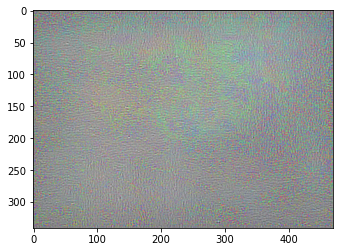

In [34]:
I, W = model.result()

# NCHW to NHWC
I = np.transpose(I, [0, 2, 3, 1]) 
W = np.transpose(W, [0, 2, 3, 1]) 

plt.imshow(PlotImage(I[0]))

print(I.shape)

for i in range(I.shape[0]):
  img = cv2.resize(I[i], (original_shape[i][0], original_shape[i][0]))
  cv2.imwrite(img, os.path.join(resultdir, filenames[i]))


